## Predict which Tweets are about real disasters and which ones are not

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string 
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from fastai.text import *
from fastai.callbacks import *

nltk.download('stopwords')
from nltk.corpus import stopwords 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/my_projects/datasets/disaster_tweets/nlp-getting-started.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/my_projects/datasets/disaster_tweets/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### Initial analysis of the train and test datasets

In [103]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv('test.csv')

In [ ]:
print(train_data.shape), train_data.head()

(7613, 5)


(None,
    id keyword  ...                                               text target
 0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
 1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
 2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
 3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
 4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1
 
 [5 rows x 5 columns])

In [ ]:
print(test_data.shape), test_data.head()

(3263, 4)


(None,
    id keyword location                                               text
 0   0     NaN      NaN                 Just happened a terrible car crash
 1   2     NaN      NaN  Heard about #earthquake is different cities, s...
 2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
 3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
 4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan)

In [ ]:
print(f" Sample for a a real disaster tweet:\n {train_data[train_data.target == 1].text.sample().values[0]}")

 Sample for a a real disaster tweet:
 #Russia 'food crematoria' provoke outrage in country w/soaring poverty +Soviet famine memory http://t.co/vymOuZjZRe http://t.co/eNRJh5Qkve


Check if `keyword` and `location` variables can be useful for the prediction task
  - There seems to be missing values in the dataset: check how many.


In [ ]:
missing_vals_train = train_data[['keyword', 'location','text']].isna().sum().reset_index()
missing_vals_train.columns = ['variable', '# missing values']
print('Training set:\n',missing_vals_train)

missing_vals_test = test_data[['keyword', 'location','text']].isna().sum().reset_index()
missing_vals_test.columns = ['variable', '# missing values']
print('\nTest set:\n',missing_vals_test)

Training set:
    variable  # missing values
0   keyword                61
1  location              2533
2      text                 0

Test set:
    variable  # missing values
0   keyword                26
1  location              1105
2      text                 0


- `location` has too many missing values to be useful, therefore, we won't use it

We should check if there are distinct `keyword` values that help for the prediction.

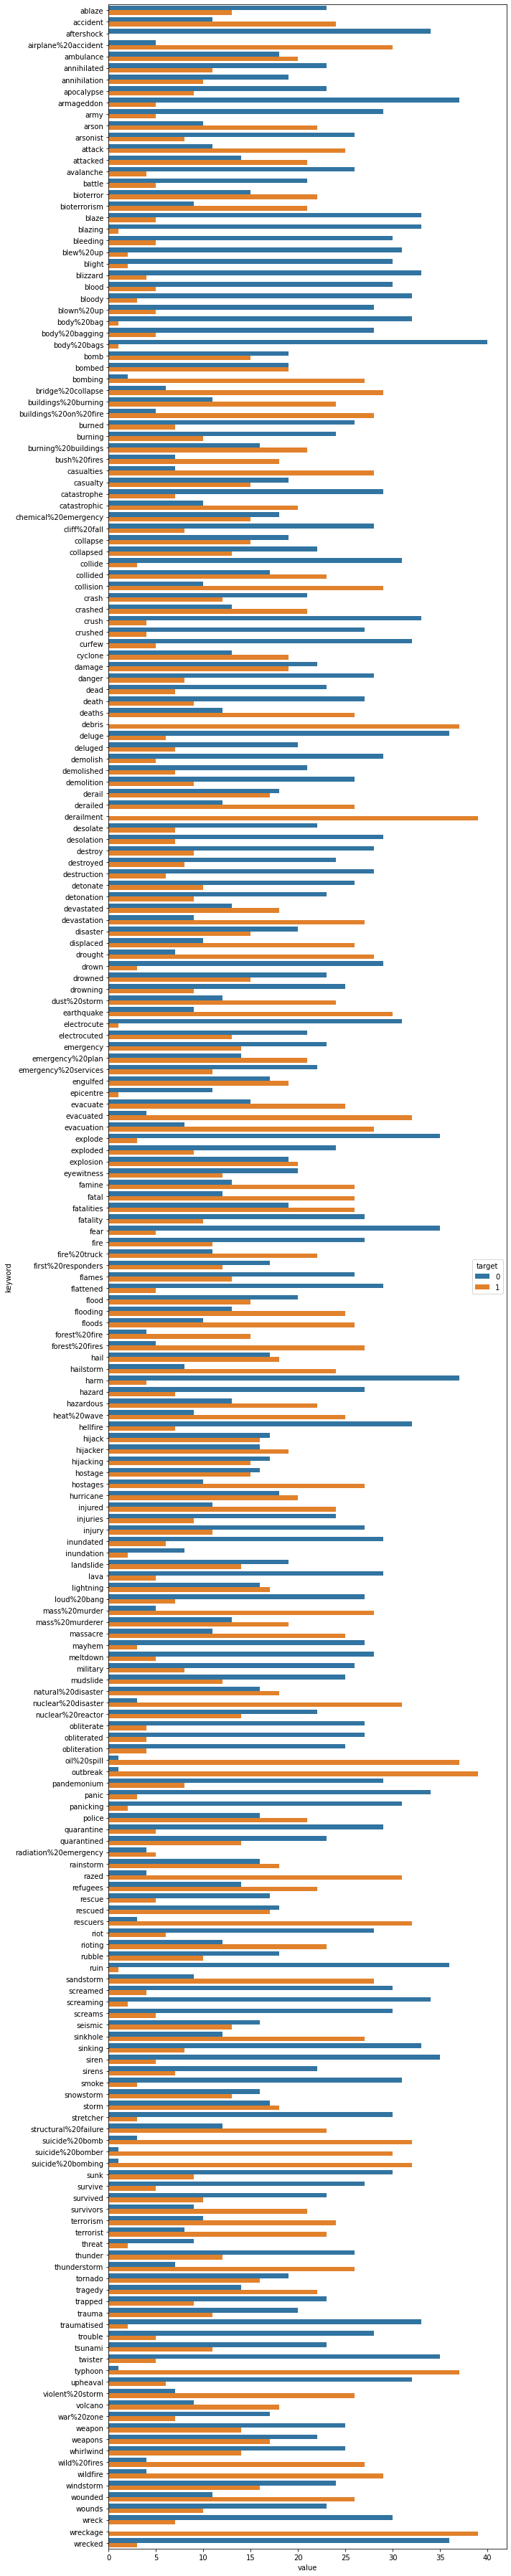

In [ ]:
train_keywords = train_data.groupby('target').keyword.value_counts().unstack().T
train_keywords = train_keywords.melt(ignore_index=False).reset_index()
train_keywords.sort_values(['keyword','target','value'])

plt.figure(figsize=(10,50))
sns.barplot(y='keyword'
            , x = 'value'
            , hue = 'target'
            , data = train_keywords
            )

plt.tight_layout()

It does seem that certain keywords are used frequently in each target group. Therefore, it would make sense to use `keyword` values as an input for the model

### Cleaning the tweets

`clean` func. taken from [NLP with Disaster Tweets - EDA, Cleaning and BERT](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#0.-Introduction-and-References)

In [104]:
def clean(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
    tweet = re.sub(r"won\'t", "will not", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would", tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)

    # tweet = re.sub(r"$" , " dollar ", tweet)
    # tweet = re.sub(r"€" , " euro ", tweet)
    # tweet = re.sub(r"4ao" , "for adults only", tweet)
    # tweet = re.sub(r"a.m" , "before midday", tweet)
    # tweet = re.sub(r"a3" , "anytime anywhere anyplace", tweet)
    # tweet = re.sub(r"aamof" , "as a matter of fact", tweet)
    # tweet = re.sub(r"acct" , "account", tweet)
    # tweet = re.sub(r"adih" , "another day in hell", tweet)
    # tweet = re.sub(r"afaic" , "as far as i am concerned", tweet)
    # tweet = re.sub(r"afaict" , "as far as i can tell", tweet)
    tweet = re.sub(r"afaik" , "as far as i know", tweet)
    tweet = re.sub(r"afair" , "as far as i remember", tweet)
    # tweet = re.sub(r"afk" , "away from keyboard", tweet)
    tweet = re.sub(r"app" , "application", tweet)
    tweet = re.sub(r"approx" , "approximately", tweet)
    # tweet = re.sub(r"apps" , "applications", tweet)
    tweet = re.sub(r"asap" , "as soon as possible", tweet)
    # tweet = re.sub(r"asl" , "age, sex, location", tweet)
    # tweet = re.sub(r"atk" , "at the keyboard", tweet)
    # tweet = re.sub(r"ave." , "avenue", tweet)
    # tweet = re.sub(r"aymm" , "are you my mother", tweet)
    # tweet = re.sub(r"ayor" , "at your own risk", tweet) 
    tweet = re.sub(r"b&b" , "bed and breakfast", tweet)
    tweet = re.sub(r"b+b" , "bed and breakfast", tweet)
    # tweet = re.sub(r"b.c" , "before christ", tweet)
    tweet = re.sub(r"b2b" , "business to business", tweet)
    tweet = re.sub(r"b2c" , "business to customer", tweet)
    tweet = re.sub(r"b4" , "before", tweet)
    tweet = re.sub(r"b4n" , "bye for now", tweet)
    # tweet = re.sub(r"b@u" , "back at you", tweet)
    # tweet = re.sub(r"bae" , "before anyone else", tweet)
    # tweet = re.sub(r"bak" , "back at keyboard", tweet)
    # tweet = re.sub(r"bbbg" , "bye bye be good", tweet)
    # tweet = re.sub(r"bbc" , "british broadcasting corporation", tweet)
    # tweet = re.sub(r"bbias" , "be back in a second", tweet)
    # tweet = re.sub(r"bbl" , "be back later", tweet)
    # tweet = re.sub(r"bbs" , "be back soon", tweet)
    # tweet = re.sub(r"be4" , "before", tweet)
    # tweet = re.sub(r"bfn" , "bye for now", tweet)
    # tweet = re.sub(r"blvd" , "boulevard", tweet)
    # tweet = re.sub(r"bout" , "about", tweet)
    # tweet = re.sub(r"brb" , "be right back", tweet)
    tweet = re.sub(r"bros" , "brothers", tweet)
    # tweet = re.sub(r"brt" , "be right there", tweet)
    # tweet = re.sub(r"bsaaw" , "big smile and a wink", tweet)
    tweet = re.sub(r"btw" , "by the way", tweet)
    # tweet = re.sub(r"bwl" , "bursting with laughter", tweet)
    # tweet = re.sub(r"c/o" , "care of", tweet)
    # tweet = re.sub(r"cet" , "central european time", tweet)
    # tweet = re.sub(r"cf" , "compare", tweet)
    # tweet = re.sub(r"cia" , "central intelligence agency", tweet)
    # tweet = re.sub(r"csl" , "can not stop laughing", tweet)
    # tweet = re.sub(r"cu" , "see you", tweet)
    # tweet = re.sub(r"cul8r" , "see you later", tweet)
    # tweet = re.sub(r"cv" , "curriculum vitae", tweet)
    # tweet = re.sub(r"cwot" , "complete waste of time", tweet)
    tweet = re.sub(r"cya" , "see you", tweet)
    tweet = re.sub(r"cyt" , "see you tomorrow", tweet)
    # tweet = re.sub(r"dae" , "does anyone else", tweet)
    # tweet = re.sub(r"dbmib" , "do not bother me i am busy", tweet)
    tweet = re.sub(r"diy" , "do it yourself", tweet)
    tweet = re.sub(r"dm" , "direct message", tweet)
    # tweet = re.sub(r"dwh" , "during work hours", tweet)
    # tweet = re.sub(r"e123" , "easy as one two three", tweet)
    # tweet = re.sub(r"eet" , "eastern european time", tweet)
    tweet = re.sub(r"eg" , "example", tweet)
    # tweet = re.sub(r"embm" , "early morning business meeting", tweet)
    # tweet = re.sub(r"encl" , "enclosed", tweet)
    # tweet = re.sub(r"encl." , "enclosed", tweet)
    # tweet = re.sub(r"etc" , "and so on", tweet)
    tweet = re.sub(r"faq" , "frequently asked questions", tweet)
    # tweet = re.sub(r"fawc" , "for anyone who cares", tweet)
    tweet = re.sub(r"fb" , "facebook", tweet)
    # tweet = re.sub(r"fc" , "fingers crossed", tweet)
    # tweet = re.sub(r"fig" , "figure", tweet)
    # tweet = re.sub(r"fimh" , "forever in my heart", tweet) 
    # tweet = re.sub(r"ft." , "feet", tweet)
    # tweet = re.sub(r"ft" , "featuring", tweet)
    # tweet = re.sub(r"ftl" , "for the loss", tweet)
    tweet = re.sub(r"ftw" , "for the win", tweet)
    # tweet = re.sub(r"fwiw" , "for what it is worth", tweet)
    tweet = re.sub(r"fyi" , "for your information", tweet)
    # tweet = re.sub(r"g9" , "genius", tweet)
    # tweet = re.sub(r"gahoy" , "get a hold of yourself", tweet)
    # tweet = re.sub(r"gal" , "get a life", tweet)
    # tweet = re.sub(r"gcse" , "general certificate of secondary education", tweet)
    # tweet = re.sub(r"gfn" , "gone for now", tweet)
    # tweet = re.sub(r"gg" , "good game", tweet)
    # tweet = re.sub(r"gl" , "good luck", tweet)
    # tweet = re.sub(r"glhf" , "good luck have fun", tweet)
    # tweet = re.sub(r"gmt" , "greenwich mean time", tweet)
    # tweet = re.sub(r"gmta" , "great minds think alike", tweet)
    tweet = re.sub(r"gn" , "good night", tweet)
    # tweet = re.sub(r"g.o.a.t" , "greatest of all time", tweet)
    # tweet = re.sub(r"goat" , "greatest of all time", tweet)
    # tweet = re.sub(r"goi" , "get over it", tweet)
    # tweet = re.sub(r"gps" , "global positioning system", tweet)
    # tweet = re.sub(r"gr8" , "great", tweet)
    # tweet = re.sub(r"gratz" , "congratulations", tweet)
    # tweet = re.sub(r"gyal" , "girl", tweet)
    # tweet = re.sub(r"h&c" , "hot and cold", tweet)
    # tweet = re.sub(r"hp" , "horsepower", tweet)
    # tweet = re.sub(r"hr" , "hour", tweet)
    # tweet = re.sub(r"hrh" , "his royal highness", tweet)
    # tweet = re.sub(r"ht" , "height", tweet)
    # tweet = re.sub(r"ibrb" , "i will be right back", tweet)
    # tweet = re.sub(r"ic" , "i see", tweet)
    # tweet = re.sub(r"icq" , "i seek you", tweet)
    # tweet = re.sub(r"icymi" , "in case you missed it", tweet)
    # tweet = re.sub(r"idc" , "i do not care", tweet)
    # tweet = re.sub(r"idgadf" , "i do not give a damn fuck", tweet)
    # tweet = re.sub(r"idgaf" , "i do not give a fuck", tweet)
    tweet = re.sub(r"idk" , "i do not know", tweet)
    #tweet = re.sub(r"ie" , "that is", tweet)
    tweet = re.sub(r"i.e" , "that is", tweet)
    # tweet = re.sub(r"ifyp" , "i feel your pain", tweet)
    tweet = re.sub(r"IG" , "instagram", tweet)
    tweet = re.sub(r"iirc" , "if i remember correctly", tweet)
    # tweet = re.sub(r"ilu" , "i love you", tweet)
    # tweet = re.sub(r"ily" , "i love you", tweet)
    tweet = re.sub(r"imho" , "in my humble opinion", tweet)
    tweet = re.sub(r"imo" , "in my opinion", tweet)
    # tweet = re.sub(r"imu" , "i miss you", tweet)
    # tweet = re.sub(r"iow" , "in other words", tweet)
    # tweet = re.sub(r"irl" , "in real life", tweet)
    # tweet = re.sub(r"j4f" , "just for fun", tweet)
    # tweet = re.sub(r"jic" , "just in case", tweet)
    # tweet = re.sub(r"jk" , "just kidding", tweet)
    # tweet = re.sub(r"jsyk" , "just so you know", tweet)
    # tweet = re.sub(r"l8r" , "later", tweet)
    # tweet = re.sub(r"lb" , "pound", tweet)
    # tweet = re.sub(r"lbs" , "pounds", tweet)
    # tweet = re.sub(r"ldr" , "long distance relationship", tweet)
    tweet = re.sub(r"lmao" , "laugh my ass off", tweet)
    tweet = re.sub(r"lmfao" , "laugh my fucking ass off", tweet)
    tweet = re.sub(r"lol" , "laughing out loud", tweet)
    # tweet = re.sub(r"ltd" , "limited", tweet)
    # tweet = re.sub(r"ltns" , "long time no see", tweet)
    # tweet = re.sub(r"m8" , "mate", tweet)
    # tweet = re.sub(r"mf" , "motherfucker", tweet)
    # tweet = re.sub(r"mfs" , "motherfuckers", tweet)
    # tweet = re.sub(r"mfw" , "my face when", tweet)
    # tweet = re.sub(r"mofo" , "motherfucker", tweet)
    # tweet = re.sub(r"mph" , "miles per hour", tweet)
    # tweet = re.sub(r"mr" , "mister", tweet)
    # tweet = re.sub(r"mrw" , "my reaction when", tweet)
    # tweet = re.sub(r"ms" , "miss", tweet)
    # tweet = re.sub(r"mte" , "my thoughts exactly", tweet)
    # tweet = re.sub(r"nagi" , "not a good idea", tweet)
    # tweet = re.sub(r"nbc" , "national broadcasting company", tweet)
    # tweet = re.sub(r"nbd" , "not big deal", tweet)
    # tweet = re.sub(r"nfs" , "not for sale", tweet)
    # tweet = re.sub(r"ngl" , "not going to lie", tweet)
    # tweet = re.sub(r"nhs" , "national health service", tweet)
    # tweet = re.sub(r"nrn" , "no reply necessary", tweet)
    # tweet = re.sub(r"nsfl" , "not safe for life", tweet)
    # tweet = re.sub(r"nsfw" , "not safe for work", tweet)
    # tweet = re.sub(r"nth" , "nice to have", tweet)
    # tweet = re.sub(r"nvr" , "never", tweet)
    # tweet = re.sub(r"nyc" , "new york city", tweet)
    # tweet = re.sub(r"oc" , "original content", tweet)
    # tweet = re.sub(r"og" , "original", tweet)
    # tweet = re.sub(r"ohp" , "overhead projector", tweet)
    # tweet = re.sub(r"oic" , "oh i see", tweet)
    # tweet = re.sub(r"omdb" , "over my dead body", tweet)
    tweet = re.sub(r"omg" , "oh my god", tweet)
    # tweet = re.sub(r"omw" , "on my way", tweet)
    # tweet = re.sub(r"p.a" , "per annum", tweet)
    # tweet = re.sub(r"p.m" , "after midday", tweet)
    # tweet = re.sub(r"pm" , "prime minister", tweet)
    # tweet = re.sub(r"poc" , "people of color", tweet)
    # tweet = re.sub(r"pov" , "point of view", tweet)
    # tweet = re.sub(r"pp" , "pages", tweet)
    tweet = re.sub(r"ppl" , "people", tweet)
    # tweet = re.sub(r"prw" , "parents are watching", tweet)
    # tweet = re.sub(r"ps" , "postscript", tweet)
    # tweet = re.sub(r"pt" , "point", tweet)
    # tweet = re.sub(r"ptb" , "please text back", tweet)
    # tweet = re.sub(r"pto" , "please turn over", tweet)
    # tweet = re.sub(r"qpsa" , "what happens", tweet) #"que pasa", tweet)
    # tweet = re.sub(r"ratchet" , "rude", tweet)
    # tweet = re.sub(r"rbtl" , "read between the lines", tweet)
    # tweet = re.sub(r"rlrt" , "real life retweet", tweet) 
    tweet = re.sub(r"rofl" , "rolling on the floor laughing", tweet)
    tweet = re.sub(r"roflol" , "rolling on the floor laughing out loud", tweet)
    tweet = re.sub(r"rotflmao" , "rolling on the floor laughing my ass off", tweet)
    # tweet = re.sub(r"rt" , "retweet", tweet)
    # tweet = re.sub(r"ruok" , "are you ok", tweet)
    # tweet = re.sub(r"sfw" , "safe for work", tweet)
    # tweet = re.sub(r"sk8" , "skate", tweet)
    tweet = re.sub(r"smh" , "shake my head", tweet)
    # tweet = re.sub(r"sq" , "square", tweet)
    # tweet = re.sub(r"srsly" , "seriously", tweet) 
    # tweet = re.sub(r"ssdd" , "same stuff different day", tweet)
    tweet = re.sub(r"tbh" , "to be honest", tweet)
    # tweet = re.sub(r"tbs" , "tablespooful", tweet)
    # tweet = re.sub(r"tbsp" , "tablespooful", tweet)
    # tweet = re.sub(r"tfw" , "that feeling when", tweet)
    # tweet = re.sub(r"thks" , "thank you", tweet)
    # tweet = re.sub(r"tho" , "though", tweet)
    # tweet = re.sub(r"thx" , "thank you", tweet)
    # tweet = re.sub(r"tia" , "thanks in advance", tweet)
    # tweet = re.sub(r"til" , "today i learned", tweet)
    tweet = re.sub(r"tl;dr" , "too long i did not read", tweet)
    tweet = re.sub(r"tldr" , "too long i did not read", tweet)
    # tweet = re.sub(r"tmb" , "tweet me back", tweet)
    # tweet = re.sub(r"tntl" , "trying not to laugh", tweet)
    # tweet = re.sub(r"ttyl" , "talk to you later", tweet)
    # tweet = re.sub(r"u" , "you", tweet)
    # tweet = re.sub(r"u2" , "you too", tweet)
    # tweet = re.sub(r"u4e" , "yours for ever", tweet)
    # tweet = re.sub(r"utc" , "coordinated universal time", tweet)
    # tweet = re.sub(r"w/" , "with", tweet)
    # tweet = re.sub(r"w/o" , "without", tweet)
    # tweet = re.sub(r"w8" , "wait", tweet)
    # tweet = re.sub(r"wassup" , "what is up", tweet)
    # tweet = re.sub(r"wb" , "welcome back", tweet)
    tweet = re.sub(r"wtf" , "what the fuck", tweet)
    # tweet = re.sub(r"wtg" , "way to go", tweet)
    # tweet = re.sub(r"wtpa" , "where the party at", tweet)
    # tweet = re.sub(r"wuf" , "where are you from", tweet)
    tweet = re.sub(r"wuzup" , "what is up", tweet)
    # tweet = re.sub(r"wywh" , "wish you were here", tweet)
    # tweet = re.sub(r"yd" , "yard", tweet)
    # tweet = re.sub(r"ygtr" , "you got that right", tweet)
    # tweet = re.sub(r"ynk" , "you never know", tweet)
    tweet = re.sub(r"zzz" , "sleeping bored and tired", tweet)



    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
    tweet = re.sub(r"cnewslive", "C News Live", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"foodscare", "food scare", tweet)
    tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
    tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
    tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
    tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
    tweet = re.sub(r"spinningbot", "spinning bot", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"po_st", "po.st", tweet)
    tweet = re.sub(r"scoopit", "scoop.it", tweet)
    tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
    tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
    tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
    tweet = re.sub(r"rapidcity", "Rapid City", tweet)
    tweet = re.sub(r"OutBid", "outbid", tweet)
    tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
    tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
    tweet = re.sub(r"15PM", "15 PM", tweet)
    tweet = re.sub(r"OriginalFunko", "Funko", tweet)
    tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
    tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
    tweet = re.sub(r"RT_America", "RT America", tweet)
    tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
    tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
    tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
    tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
    tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
    tweet = re.sub(r"gunsense", "gun sense", tweet)
    tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
    tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
    tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
    tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
    tweet = re.sub(r"renew911health", "renew 911 health", tweet)
    tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
    tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
    tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
    tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
    tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
    tweet = re.sub(r"pdx911", "Portland Police", tweet)
    tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
    tweet = re.sub(r"Japton", "Arkansas", tweet)
    tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
    tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
    tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
    tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
    tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
    tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
    tweet = re.sub(r"versethe", "verse the", tweet)
    tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
    tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
    tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
    tweet = re.sub(r"NANKANA", "Nankana", tweet)
    tweet = re.sub(r"SAHIB", "Sahib", tweet)
    tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
    tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
    tweet = re.sub(r"gofundme", "go fund me", tweet)
    tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
    tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
    tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
    tweet = re.sub(r"bancodeseries", "banco de series", tweet)
    tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
    tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
    tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
    tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
    tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
    tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
    tweet = re.sub(r"Kowing", "Knowing", tweet)
    tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
    tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
    tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
    tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
    tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
    tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
    tweet = re.sub(r"Ptbo", "Peterborough", tweet)
    tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
    tweet = re.sub(r"IndianNews", "Indian News", tweet)
    tweet = re.sub(r"savebees", "save bees", tweet)
    tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
    tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
    tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
    tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
    tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
    tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
    tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
    tweet = re.sub(r"Daesh", "ISIS", tweet)
    tweet = re.sub(r"s2g", "swear to god", tweet)
    tweet = re.sub(r"listenlive", "listen live", tweet)
    tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
    tweet = re.sub(r"FoxNew", "Fox News", tweet)
    tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
    tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
    tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
    tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
    tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
    tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
    tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
    tweet = re.sub(r"HORNDALE", "Horndale", tweet)
    tweet = re.sub(r"PINER", "Piner", tweet)
    tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
    tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
    tweet = re.sub(r"residualincome", "residual income", tweet)
    tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
    tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
    tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
    tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
    tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
    tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
    tweet = re.sub(r"pop2015", "pop 2015", tweet)
    tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
    tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
    tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
    tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
    tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
    tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
    tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
    tweet = re.sub(r"EndConflict", "End Conflict", tweet)
    tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
    tweet = re.sub(r"UNHEALED", "unhealed", tweet)
    tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
    tweet = re.sub(r"Latestnews", "Latest news", tweet)
    tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
    tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
    tweet = re.sub(r"datingtips", "dating tips", tweet)
    tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
    tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
    tweet = re.sub(r"txlege", "Texas Legislature", tweet)
    tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
    tweet = re.sub(r"Newss", "News", tweet)
    tweet = re.sub(r"hempoil", "hemp oil", tweet)
    tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
    tweet = re.sub(r"tubestrike", "tube strike", tweet)
    tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
    tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
    tweet = re.sub(r"TI5", "The International 5", tweet)
    tweet = re.sub(r"thehill", "the hill", tweet)
    tweet = re.sub(r"3others", "3 others", tweet)
    tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
    tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
    tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
    tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
    tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
    tweet = re.sub(r"offdishduty", "off dish duty", tweet)
    tweet = re.sub(r"andword", "and word", tweet)
    tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
    tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
    tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"57am", "57 am", tweet)
    tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
    tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
    tweet = re.sub(r"newnewnew", "new new new", tweet)
    tweet = re.sub(r"under50", "under 50", tweet)
    tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
    tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
    tweet = re.sub(r"amwriting", "am writing", tweet)
    tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
    tweet = re.sub(r"Nowlike", "Now like", tweet)
    tweet = re.sub(r"seasonfrom", "season from", tweet)
    tweet = re.sub(r"epicente", "epicenter", tweet)
    tweet = re.sub(r"epicenterr", "epicenter", tweet)
    tweet = re.sub(r"sicklife", "sick life", tweet)
    tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
    tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
    tweet = re.sub(r"approachng", "approaching", tweet)
    tweet = re.sub(r"evng", "evening", tweet)
    tweet = re.sub(r"Sumthng", "something", tweet)
    tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
    tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
    tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
    tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
    tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
    tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
    tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
    tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
    tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
    tweet = re.sub(r"TCMParty", "TCM Party", tweet)
    tweet = re.sub(r"marijuananews", "marijuana news", tweet)
    tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
    tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
    tweet = re.sub(r"newauthors", "new authors", tweet)
    tweet = re.sub(r"remedyyyy", "remedy", tweet)
    tweet = re.sub(r"44PM", "44 PM", tweet)
    tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
    tweet = re.sub(r"40PM", "40 PM", tweet)
    tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
    tweet = re.sub(r"ithats", "that is", tweet)
    tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
    tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
    tweet = re.sub(r"02PM", "02 PM", tweet)
    tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"Bstrd", "bastard", tweet)
    tweet = re.sub(r"bldy", "bloody", tweet)
    tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
    tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
    tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
    tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
    tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
    tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
    tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
    tweet = re.sub(r"incubusband", "incubus band", tweet)
    tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
    tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
    tweet = re.sub(r"win10", "Windows 10", tweet)
    tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
    tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
    tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
    tweet = re.sub(r"crewlist", "crew list", tweet)
    tweet = re.sub(r"Erdogans", "Erdogan", tweet)
    tweet = re.sub(r"BBCLive", "BBC Live", tweet)
    tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
    tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
    tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
    tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
    tweet = re.sub(r"pctool", "pc tool", tweet)
    tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
    tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
    tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
    tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
    tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
    tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
    tweet = re.sub(r"writerslife", "writers life", tweet)
    tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
    tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
    tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
    tweet = re.sub(r"acreativedc", "a creative DC", tweet)
    tweet = re.sub(r"vscodc", "vsco DC", tweet)
    tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
    tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
    tweet = re.sub(r"buildingmuseum", "building museum", tweet)
    tweet = re.sub(r"WorldOil", "World Oil", tweet)
    tweet = re.sub(r"redwedding", "red wedding", tweet)
    tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
    tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
    tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
    tweet = re.sub(r"bleased", "blessed", tweet)
    tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
    tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
    tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
    tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
    tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
    tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
    tweet = re.sub(r"dirtylying", "dirty lying", tweet)
    tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
    tweet = re.sub(r"changetheworld", "change the world", tweet)
    tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
    tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
    tweet = re.sub(r"withweapons", "with weapons", tweet)
    tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
    tweet = re.sub(r"letsFootball", "let us Football", tweet)
    tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
    tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
    tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
    tweet = re.sub(r"22PM", "22 PM", tweet)
    tweet = re.sub(r"54am", "54 AM", tweet)
    tweet = re.sub(r"38am", "38 AM", tweet)
    tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
    tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
    tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
    tweet = re.sub(r"2k15", "2015", tweet)
    tweet = re.sub(r"TheIran", "Iran", tweet)
    tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
    tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
    tweet = re.sub(r"defense_news", "defense news", tweet)
    tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
    tweet = re.sub(r"Auspol", "Australia Politics", tweet)
    tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
    tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
    tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
    tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
    tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
    tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
    tweet = re.sub(r"toopainful", "too painful", tweet)
    tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
    tweet = re.sub(r"NoNukes", "No Nukes", tweet)
    tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
    tweet = re.sub(r"ineedcake", "I need cake", tweet)
    tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
    tweet = re.sub(r"BBCOne", "BBC One", tweet)
    tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
    tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
    tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
    tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
    tweet = re.sub(r"irongiant", "iron giant", tweet)
    tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
    tweet = re.sub(r"TimCook", "Tim Cook", tweet)
    tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
    tweet = re.sub(r"Madsummer", "Mad summer", tweet)
    tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
    tweet = re.sub(r"concertphotography", "concert photography", tweet)
    tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
    tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
    tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
    tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
    tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
    tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
    tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
    tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
    tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
    tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
    tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
    tweet = re.sub(r"NotSorry", "not sorry", tweet)
    tweet = re.sub(r"UseYourWords", "use your words", tweet)
    tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
    tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
    tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
    tweet = re.sub(r"jokethey", "joke they", tweet)
    tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
    tweet = re.sub(r"uiseful", "useful", tweet)
    tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
    tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
    tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
    tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
    tweet = re.sub(r"birdgang", "bird gang", tweet)
    tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
    tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
    tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
    tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
    tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
    tweet = re.sub(r"TOI_India", "The Times of India", tweet)
    tweet = re.sub(r"hegot", "he got", tweet)
    tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
    tweet = re.sub(r"sothathappened", "so that happened", tweet)
    tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
    tweet = re.sub(r"NationFirst", "Nation First", tweet)
    tweet = re.sub(r"IndiaToday", "India Today", tweet)
    tweet = re.sub(r"HLPS", "helps", tweet)
    tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
    tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
    tweet = re.sub(r"BidTime", "Bid Time", tweet)
    tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
    tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
    tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
    tweet = re.sub(r"eatshit", "eat shit", tweet)
    tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
    tweet = re.sub(r"SahelNews", "Sahel News", tweet)
    tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
    tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
    tweet = re.sub(r"facilitydude", "facility dude", tweet)
    tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
    tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
    tweet = re.sub(r"MarketResearch", "Market Research", tweet)
    tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
    tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
    tweet = re.sub(r"yychail", "Calgary hail", tweet)
    tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
    tweet = re.sub(r"eliotschool", "eliot school", tweet)
    tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
    tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
    tweet = re.sub(r"RiverComplex", "River Complex", tweet)
    tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
    tweet = re.sub(r"IranElection", "Iran Election", tweet)
    tweet = re.sub(r"glowng", "glowing", tweet)
    tweet = re.sub(r"kindlng", "kindling", tweet)
    tweet = re.sub(r"riggd", "rigged", tweet)
    tweet = re.sub(r"slownewsday", "slow news day", tweet)
    tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
    tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
    tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
    tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
    tweet = re.sub(r"netbots", "net bots", tweet)
    tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
    tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
    tweet = re.sub(r"EndofUS", "End of United States", tweet)
    tweet = re.sub(r"35PM", "35 PM", tweet)
    tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
    tweet = re.sub(r"76mins", "76 minutes", tweet)
    tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
    tweet = re.sub(r"livesmatter", "lives matter", tweet)
    tweet = re.sub(r"myhometown", "my hometown", tweet)
    tweet = re.sub(r"tankerfire", "tanker fire", tweet)
    tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
    tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
    tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
    tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
    tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
    tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
    tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
    tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
    tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
    tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
    tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
    tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
    tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
    tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
    tweet = re.sub(r"kostumes", "costumes", tweet)
    tweet = re.sub(r"YEEESSSS", "yes", tweet)
    tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
    tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
    tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
    tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
    tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
    tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
    tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
    tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
    tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
    tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
    tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
    tweet = re.sub(r"FromTheField", "From the field", tweet)
    tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
    tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
    tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
    tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
    tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
    tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
    tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
    tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
    tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
    tweet = re.sub(r"Evaucation", "evacuation", tweet)
    tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
    tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
    tweet = re.sub(r"Tubestrike", "tube strike", tweet)
    tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
    tweet = re.sub(r"localplumber", "local plumber", tweet)
    tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
    tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
    tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
    tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
    tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
    tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
    tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
    tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
    tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
    tweet = re.sub(r"wfocus", "focus", tweet)
    tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
    tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
    tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
    tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
    tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
    tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
    tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
    tweet = re.sub(r"bedhair", "bed hair", tweet)
    tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
    tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
    # Urls
    tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)

    # Replace amp
    tweet = re.sub(r" amp ", " and ", tweet)
    
    return tweet

In [105]:
train_data['text_cleaned'] = train_data['text'].apply(lambda s : clean(s))
test_data['text_cleaned'] = test_data['text'].apply(lambda s : clean(s))

In [106]:
# Re-labelling the mis-labeled tweets
df_mislabeled = train_data.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

In [107]:
train_data.loc[train_data['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target'] = 0
train_data.loc[train_data['text']  == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target'] = 0
train_data.loc[train_data['text']  == 'To fight bioterrorism sir.', 'target'] = 0
train_data.loc[train_data['text']  == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target'] = 1
train_data.loc[train_data['text']  == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target'] = 1
train_data.loc[train_data['text']  == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target'] = 0
train_data.loc[train_data['text']  == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target'] = 0
train_data.loc[train_data['text']  == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target'] = 1
train_data.loc[train_data['text']  == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target'] = 1
train_data.loc[train_data['text']  == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target'] = 0
train_data.loc[train_data['text']  == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target'] = 0
train_data.loc[train_data['text']  == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target'] = 0
train_data.loc[train_data['text']  == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target'] = 0
train_data.loc[train_data['text']  == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target'] = 0
train_data.loc[train_data['text']  == "Caution: breathing may be hazardous to your health.", 'target'] = 1
train_data.loc[train_data['text']  == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target'] = 0
train_data.loc[train_data['text']  == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target'] = 0
train_data.loc[train_data['text']  == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target'] = 0

### Generating additional features from the dataset

In [108]:
# replace the missing 'Keyword' values and clean the data
train_data.keyword.replace(np.nan,'missing',inplace=True)
test_data.keyword.replace(np.nan,'missing',inplace=True)

In [113]:
train_data.keyword = train_data.keyword.apply(lambda s : clean(s))
test_data.keyword = test_data.keyword.apply(lambda s : clean(s))

AttributeError: ignored

In [ ]:
def generate_features(df): 

  # word_count
  df['word_count'] = df['text_cleaned'].apply(lambda x: len(str(x).split()))

  # unique_word_count
  df['unique_word_count'] = df['text_cleaned'].apply(lambda x: len(set(str(x).split())))

  # url_count
  df['url_count'] = df['text_cleaned'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

  # char_count
  df['char_count'] = df['text_cleaned'].apply(lambda x: len(str(x)))

  # punctuation_count
  df['punctuation_count'] = df['text_cleaned'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

  # mean_word_length
  df['mean_word_length'] = df['text_cleaned'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

  # stop_word_count
  stop_words = set(stopwords.words('english'))
  df['stop_word_count'] = df['text_cleaned'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

  # hashtag_count
  df['hashtag_count'] = df['text_cleaned'].apply(lambda x: len([c for c in str(x) if c == '#']))

  # mention_count
  df['mention_count'] = df['text_cleaned'].apply(lambda x: len([c for c in str(x) if c == '@']))

  # one-hot-encode the 'keywords'
  one_hot = pd.get_dummies(df['keyword'])
  df = df.drop('keyword',axis = 1)
  df = df.join(one_hot)

  return df

In [ ]:
train_data = generate_features(train_data)
test_data = generate_features(test_data)

In [114]:
train_data.head()

,id,location,text,target,text_cleaned,word_count,unique_word_count,url_count,char_count,punctuation_count,mean_word_length,stop_word_count,hashtag_count,mention_count,ablaze,accthat isnt,aftershock,airplane % 20accthat isnt,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew % 20up,blight,blizzard,blood,bloody,...,sthat isns,storm,stretcher,structural % 20failure,suicthat is % 20bomb,suicthat is % 20bomber,suicthat is % 20bombing,sunk,survivors,survthat is,survthat isd,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapeopleicationed,trauma,traumatthat isd,trouble,tsunami,twister,typhoon,upheaval,violent % 20storm,volcano,war % 20zone,weapon,weapons,whirlwind,wild % 20fthat iss,wildfthat is,windstorm,wounded,wounds,wreck,wreckage,wrecked
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this # earthquake...,15,15,0,75,1,4.000000,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fthat is near La Ronge Sask . Canada,9,9,0,44,1,3.888889,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,NaN,All residents asked to 'shelter in place' are ...,1,All resthat isnts asked to ishelter in place ...,26,23,0,146,2,4.538462,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people recethat is # wildfthat iss eva...",11,11,0,75,2,5.727273,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby # Alaska a...,19,17,0,96,2,3.947368,7,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Using Fast-AI

In [115]:
all_X_cols = train_data.columns.tolist()
all_X_cols.remove('target')
y_cols = ['id', 'target']

In [116]:
# create a train and validation set for the training
y = train_data.loc[:,y_cols]
X = train_data.loc[: , all_X_cols]
                   
X_train, X_val, y_train, y_val = train_test_split(X,y)

X_val.loc[:,'is_valid'] = True
X_train.loc[:,'is_valid'] = False

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [117]:
X_train_w_Y = X_train.merge(y_train)
X_val_w_Y = X_val.merge(y_val)

In [118]:
train_data_full = pd.concat([X_train_w_Y,X_val_w_Y])

In [119]:
train_data_full.head()

,id,location,text,text_cleaned,word_count,unique_word_count,url_count,char_count,punctuation_count,mean_word_length,stop_word_count,hashtag_count,mention_count,ablaze,accthat isnt,aftershock,airplane % 20accthat isnt,ambulance,annihilated,annihilation,apocalypse,armageddon,army,arson,arsonist,attack,attacked,avalanche,battle,bioterror,bioterrorism,blaze,blazing,bleeding,blew % 20up,blight,blizzard,blood,bloody,blown % 20up,...,stretcher,structural % 20failure,suicthat is % 20bomb,suicthat is % 20bomber,suicthat is % 20bombing,sunk,survivors,survthat is,survthat isd,terrorism,terrorist,threat,thunder,thunderstorm,tornado,tragedy,trapeopleicationed,trauma,traumatthat isd,trouble,tsunami,twister,typhoon,upheaval,violent % 20storm,volcano,war % 20zone,weapon,weapons,whirlwind,wild % 20fthat iss,wildfthat is,windstorm,wounded,wounds,wreck,wreckage,wrecked,is_valid,target
0,7345,"Dover, DE",@dicehateme @PuppyShogun This makes sense. Pap...,@ dthat ishateme @ PuppyShogun This makes se...,28,24,0,152,4,4.321429,7,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0
1,9081,"ÌÏT: 27.9136024,-81.6078532",'@CatoInstitute: The causes of federal failure...,' @ Cato Institute : The causes of federal ...,22,20,0,117,5,4.090909,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0
2,4920,"Elmwood Park, NJ",Well as I was chaning an iPad screen it fuckin...,Well as I was chaning an iPad screen it fuckin...,32,30,0,145,2,3.500000,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0
3,10265,Host of #MindMoversPodcast,the war on drugs has turned the U.S. into a WA...,the war on drugs has turned the U . S . into ...,16,13,0,59,3,2.625000,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,False,1
4,10083,NaN,Obama Declares Disaster for Typhoon-Devastated...,Obama Declares Disaster for Typhoon Devastated...,7,7,0,53,0,6.714286,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1


In [120]:
train_reduced = train_data_full.loc[:,['text_cleaned','is_valid','target']]
train_reduced.columns = ['text','is_valid','label']
train_reduced = train_reduced[['label','text','is_valid']]
train_reduced.to_csv('disaster_tweets_train_data.csv', index=False)
train_reduced

,label,text,is_valid
0,0,@ dthat ishateme @ PuppyShogun This makes se...,False
1,0,' @ Cato Institute : The causes of federal ...,False
2,0,Well as I was chaning an iPad screen it fuckin...,False
3,1,the war on drugs has turned the U . S . into ...,False
4,1,Obama Declares Disaster for Typhoon Devastated...,False
...,...,...,...
1899,0,Very glad that you got oblthat israted in X Me...,True
1900,1,Mourning notthat iss for stabed and breakfasti...,True
1901,1,Mass murderer Che Guevara greeting a woman in ...,True
1902,0,Womens Flower Printed Shoulder Handbags Cross ...,True


In [121]:
bs=32
data_lm =  (TextList.from_df(train_reduced, cols=["text"])
           .split_from_df("is_valid")
           .label_for_lm()
           .databunch(bs=bs))

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [188]:
lm = language_model_learner(data_lm
                            , AWD_LSTM
                            , drop_mult=0.2
                            , pretrained=True)

In [189]:
lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-01
Min loss divided by 10: 4.37E-02


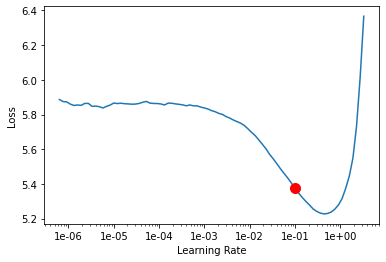

In [190]:
lm.recorder.plot(suggestion=True)

In [191]:
lm.fit_one_cycle(1, max_lr = 1e-01
                 , callbacks=[SaveModelCallback(lm, name="best_lm")]
                 , moms=(0.8,0.7)
                 )

epoch,train_loss,valid_loss,accuracy,time
0,4.336561,3.780104,0.352381,00:04


Better model found at epoch 0 with valid_loss value: 3.780104398727417.


In [192]:
lm.unfreeze()

In [193]:
lm.load("best_lm")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (5709 items)
x: LMTextList
xxbos @ dthat xxunk @ xxunk xxmaj this makes sense . xxmaj paper beats rock paper comes from wood so wood should be able to support and oblthat israte rock .,xxbos ' @ xxmaj xxunk xxmaj institute : xxmaj the causes of xxunk failure are xxunk structural and they will not be easily xxunk : ',xxbos xxmaj well as i was xxunk an xxunk screen it fucking exploded and glass went all over the place . xxmaj looks lthat is my job is going to need a new one .,xxbos the war on drugs has turned the u . s . into a xxup war zone .,xxbos xxmaj obama xxmaj declares xxmaj disaster for xxmaj typhoon xxmaj devastated xxmaj saipan
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (1904 items)
x: LMTextList
xxbos xxmaj so you have a new weapon that can cause un - xxunk destruction .,xxbos xxmaj the f $ & @ xxunk things i do for # xxup xxunk xxmaj just got xxunk in a deluge going for xxunk and xxunk . xxmaj thx @ xxmaj xxunk xxmaj

In [194]:
lm.save_encoder("enc")

In [195]:
data_clf = (TextList.from_df(train_reduced, cols=["text"]
                             , vocab=data_lm.vocab,)
          .split_from_df("is_valid")
          .label_from_df("label")
          .add_test(test_data['text_cleaned'])
          .databunch(bs=bs)
          )

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [196]:
clf_text = text_classifier_learner(data_clf
                                  , AWD_LSTM
                                  , drop_mult=0.2)

In [197]:
clf_text.load_encoder("enc")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5709 items)
x: TextList
xxbos @ dthat xxunk @ xxunk xxmaj this makes sense . xxmaj paper beats rock paper comes from wood so wood should be able to support and oblthat israte rock .,xxbos ' @ xxmaj xxunk xxmaj institute : xxmaj the causes of xxunk failure are xxunk structural and they will not be easily xxunk : ',xxbos xxmaj well as i was xxunk an xxunk screen it fucking exploded and glass went all over the place . xxmaj looks lthat is my job is going to need a new one .,xxbos the war on drugs has turned the u . s . into a xxup war zone .,xxbos xxmaj obama xxmaj declares xxmaj disaster for xxmaj typhoon xxmaj devastated xxmaj saipan
y: CategoryList
0,0,0,1,1
Path: .;

Valid: LabelList (1904 items)
x: TextList
xxbos xxmaj so you have a new weapon that can cause un - xxunk destruction .,xxbos xxmaj the f $ & @ xxunk things i do for # xxup xxunk xxmaj just got xxunk in a deluge going for xxunk and xxunk . xxmaj thx @ xxmaj xxunk xxmaj 

In [198]:
clf_text.lr_find()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-03
Min loss divided by 10: 6.92E-03


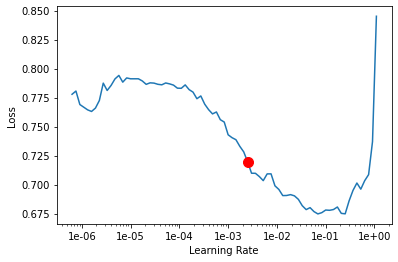

In [199]:
clf_text.recorder.plot(suggestion=True)

In [200]:
clf_text.fit(5, lr=slice(1e-02,1e-04), callbacks=[SaveModelCallback(clf_text, name="best_clf")])

epoch,train_loss,valid_loss,accuracy,time
0,0.591654,0.521573,0.746324,00:03
1,0.542800,0.503738,0.761555,00:03
2,0.531812,0.502588,0.762080,00:03
3,0.520269,0.489336,0.772059,00:03
4,0.504292,0.488596,0.769433,00:03


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 0 with valid_loss value: 0.5215733051300049.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 1 with valid_loss value: 0.50373774766922.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 2 with valid_loss value: 0.5025878548622131.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 3 with valid_loss value: 0.4893362820148468.


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 4 with valid_loss value: 0.48859623074531555.


In [201]:
clf_text.load("best_clf")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5709 items)
x: TextList
xxbos @ dthat xxunk @ xxunk xxmaj this makes sense . xxmaj paper beats rock paper comes from wood so wood should be able to support and oblthat israte rock .,xxbos ' @ xxmaj xxunk xxmaj institute : xxmaj the causes of xxunk failure are xxunk structural and they will not be easily xxunk : ',xxbos xxmaj well as i was xxunk an xxunk screen it fucking exploded and glass went all over the place . xxmaj looks lthat is my job is going to need a new one .,xxbos the war on drugs has turned the u . s . into a xxup war zone .,xxbos xxmaj obama xxmaj declares xxmaj disaster for xxmaj typhoon xxmaj devastated xxmaj saipan
y: CategoryList
0,0,0,1,1
Path: .;

Valid: LabelList (1904 items)
x: TextList
xxbos xxmaj so you have a new weapon that can cause un - xxunk destruction .,xxbos xxmaj the f $ & @ xxunk things i do for # xxup xxunk xxmaj just got xxunk in a deluge going for xxunk and xxunk . xxmaj thx @ xxmaj xxunk xxmaj 

In [202]:
clf_text.unfreeze()

In [203]:
clf_text.fit(1, lr=1e-03, callbacks=[SaveModelCallback(clf_text, name="best_clf_ft1")])

epoch,train_loss,valid_loss,accuracy,time
0,0.493136,0.433506,0.811450,00:07


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 0 with valid_loss value: 0.4335058331489563.


In [204]:
clf_text.fit(1, 1e-03, callbacks=[SaveModelCallback(clf_text, name="best_clf_ft2")])

epoch,train_loss,valid_loss,accuracy,time
0,0.389427,0.446629,0.795693,00:07


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Better model found at epoch 0 with valid_loss value: 0.4466290771961212.


In [205]:
clf_text.load("best_clf_ft1")
#clf_text.load("best_clf_ft2")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5709 items)
x: TextList
xxbos @ dthat xxunk @ xxunk xxmaj this makes sense . xxmaj paper beats rock paper comes from wood so wood should be able to support and oblthat israte rock .,xxbos ' @ xxmaj xxunk xxmaj institute : xxmaj the causes of xxunk failure are xxunk structural and they will not be easily xxunk : ',xxbos xxmaj well as i was xxunk an xxunk screen it fucking exploded and glass went all over the place . xxmaj looks lthat is my job is going to need a new one .,xxbos the war on drugs has turned the u . s . into a xxup war zone .,xxbos xxmaj obama xxmaj declares xxmaj disaster for xxmaj typhoon xxmaj devastated xxmaj saipan
y: CategoryList
0,0,0,1,1
Path: .;

Valid: LabelList (1904 items)
x: TextList
xxbos xxmaj so you have a new weapon that can cause un - xxunk destruction .,xxbos xxmaj the f $ & @ xxunk things i do for # xxup xxunk xxmaj just got xxunk in a deluge going for xxunk and xxunk . xxmaj thx @ xxmaj xxunk xxmaj 

In [206]:
# Text prediction on Validation

pred_val = clf_text.get_preds(DatasetType.Valid, ordered=True)
pred_val_l = pred_val[0].argmax(1)

# Text only prediction for Validation
print(classification_report(pred_val[1], pred_val_l))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1093
           1       0.83      0.70      0.76       811

    accuracy                           0.81      1904
   macro avg       0.82      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



In [211]:
# Submission file for Test with Text only
pred_test, label_test = clf_text.get_preds(DatasetType.Test, ordered=True)
pred_test_ = pred_test.argmax(1)
pred_test_l = [data_clf.train_ds.y.classes[n] for n in pred_test_]

res = pd.Series(pred_test_l, index=test_data['id'], name="target")

res.index.name = "id"
pd.DataFrame(res).to_csv("submission_only_text.csv")

### Using meta-features

In [156]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf_rf = RandomForestClassifier(n_estimators=1000
                               , max_depth=20
                               , min_samples_split=20
                               , min_samples_leaf=2
                               , n_jobs=-1
                               , random_state=0)

clf_rf.fit(X_train.drop(['text','text_cleaned','id','is_valid','location'], axis=1)
         , y_train.target.values
          )
clf_val_pred = clf_rf.predict_proba(X_val.drop(['text','text_cleaned','id','is_valid','location'],axis=1))

print('Validation Accuracy:', accuracy_score(y_val.target.values, clf_val_pred.argmax(axis=-1)))

Validation Accuracy: 0.7158613445378151


In [157]:
# RandomForest Prediction on validation 
print(classification_report(y_val.target.values, clf_val_pred.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.71      0.85      0.77      1093
           1       0.73      0.54      0.62       811

    accuracy                           0.72      1904
   macro avg       0.72      0.69      0.70      1904
weighted avg       0.72      0.72      0.71      1904



In [209]:
# Ensembel prediction on Validation

lang_model_weight = 0.9
rand_forest_weight = 0.1

pred_val_combined = ((clf_text.get_preds(DatasetType.Valid)[0]*lang_model_weight).detach().numpy().ravel() + (clf_val_pred.ravel()*rand_forest_weight)).reshape(-1,2).argmax(1)
print(classification_report(y_val.target.values, pred_val_combined))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84      1093
           1       0.83      0.69      0.76       811

    accuracy                           0.81      1904
   macro avg       0.82      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



In [175]:
# Submission using ensemble model

lang_model_weight = 0.9
rand_forest_weight = 0.1

clf_testpred = clf_rf.predict_proba(test_data.drop(['id','location','text','text_cleaned'],axis=1))
submission_bert = test_data.copy()[['id']]

pred_test_combi = ((clf_text.get_preds(DatasetType.Test)[0]*lang_model_weight ).detach().numpy().ravel() + (clf_testpred.ravel()*rand_forest_weight)).reshape(-1,2).argmax(1)
pred_test_l_combi = [data_clf.valid_ds.y.classes[n] for n in pred_test_combi]

res = pd.Series(pred_test_l_combi, index=test_data['id'], name="target")
res.index.name = "id"
pd.DataFrame(res).to_csv("submission_combined.csv")